# Karan Murthy

# Analysis of the PROGRESA Program in Mexico


## Introduction

This is an in-depth analysis of the [Progresa program](http://en.wikipedia.org/wiki/Oportunidades), a government social assistance program in Mexico. This program, as well as the details of its impact, are described in the paper "[School subsidies for the poor: evaluating the Mexican Progresa poverty program](http://www.sciencedirect.com/science/article/pii/S0304387803001858)", by Paul Shultz.

The goal of this problem set is to implement some of the basic econometric techniques to measure the impact of Progresa on secondary school enrollment rates. The timeline of the program was:

 * Baseline survey conducted in 1997
 * Intervention begins in 1998, "Wave 1" of data collected in 1998
 * "Wave 2 of data" collected in 1999
 * Evaluation ends in 2000, at which point the control villages were treated. 
 
The data is the actual data collected to evaluate the impact of the Progresa program.  In this file, each row corresponds to an observation taken for a given child for a given year. There are two years of data (1997 and 1998), and just under 40,000 children who are surveyed in each year. For each child-year observation, the following variables are collected:

| Variable name | Description|
|---------|---------|
|year	  |year in which data is collected
|sex	  |male = 1|
|indig	  |indigenous = 1|
|dist_sec |nearest distance to a secondary school|
|sc	      |enrolled in school in year of survey|
|grc      |grade enrolled|
|fam_n    |family size|
|min_dist |	min distance to an urban center|
|dist_cap |	min distance to the capital|
|poor     |	poor = 'pobre'|
|progresa |treatment = 'basal'|
|hohedu	  |years of schooling of head of household|
|hohwag	  |monthly wages of head of household|
|welfare_index|	welfare index used to classify poor|
|hohsex	  |gender of head of household (male=1)|
|hohage   |age of head of household|
|age      |years old|
|folnum	  |individual id|
|village  |	village id|
|sc97	  |schooling in 1997|

In [1]:
import sys; print(sys.version)
%matplotlib inline

import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from IPython.display import display, HTML


3.6.0 |Continuum Analytics, Inc.| (default, Dec 23 2016, 12:06:52) [MSC v.1900 32 bit (Intel)]


---
## Part 1: Descriptive analysis

### 1.1	Summary Statistics

a) Presenting number of missing observations for every single variable


In [3]:
# here...
progresa_df = pd.read_csv('progresa_sample.csv')
display(progresa_df.isnull().sum())

year                0
sex                24
indig             300
dist_sec            0
sc               8453
grc              6549
fam_n               0
min_dist            0
dist_cap            0
poor                0
progresa            0
hohedu              0
hohwag              0
welfare_index     210
hohsex             20
hohage             10
age                 0
village             0
folnum              0
grc97               0
sc97             3872
dtype: int64

b) Presenting summary statistics (mean and standard deviation) for all of the demographic variables in the dataset (i.e., everything except year, folnum, village).

In [4]:
# edit me :-)
summary_stats = progresa_df.describe()
summary_stats = summary_stats.loc[['mean','std'], ['age', 'sex', 'dist_cap','dist_sec', 'fam_n', 'indig', 'grc', 'grc97', 'hohage',
                                   'hohedu', 'hohwag', 'hohsex', 'min_dist', 'sc', 'sc97', 'welfare_index']]
summary_stats.T


,mean,std
age,11.366460,3.167744
sex,0.512211,0.499854
dist_cap,147.674452,76.063134
dist_sec,2.418910,2.234109
fam_n,7.215715,2.352900
indig,0.298324,0.457525
grc,3.963537,2.499063
grc97,3.705372,2.572387
hohage,44.436717,11.620372
hohedu,2.768104,2.656106


### 1.2 Differences at baseline?

Are the baseline (1997) demographic characteristics **for the poor**  different in treatment and control villages?  Focusing only on the data from 1997 for individuals who are poor (i.e., poor=='pobre').


In [5]:
progresa_df.loc[progresa_df.progresa == '0','progresa'] = 0
progresa_df.loc[progresa_df.progresa == 'basal','progresa'] = 1
progresa_df['progresa'] = progresa_df.progresa.astype('int')
progresa_df.loc[progresa_df.poor == 'no pobre','poor'] = 0
progresa_df.loc[progresa_df.poor == 'pobre','poor'] = 1
progresa_df['poor'] = progresa_df.poor.astype('int')


# Control group is the group with progresa value as 0 and Treatment group is the one 
# with progresa value 1.
control_group_97 = progresa_df[(progresa_df['year'] == 97) & (progresa_df['poor'] == 1) 
                               & (progresa_df['progresa'] == 0)]

treatment_group_97 = progresa_df[(progresa_df['year'] == 97) & (progresa_df['poor'] == 1) 
                               & (progresa_df['progresa'] == 1)]

stat_df = pd.DataFrame(columns=['Variable name', 'Average value(Treatment villages)', 'Average value(Control villages)',
                     'Difference (Treat - Control)', 'p-value'])
required_columns = ['age', 'sex', 'dist_cap','dist_sec', 'fam_n', 'indig', 'grc', 'hohage',
                                   'hohedu', 'hohwag', 'hohsex', 'min_dist', 'sc', 'welfare_index']
for var in required_columns:
    stat_df.set_value(required_columns.index(var), stat_df.columns[0], var)
    stat_df.set_value(required_columns.index(var), stat_df.columns[1], treatment_group_97[var].mean())
    stat_df.set_value(required_columns.index(var), stat_df.columns[2], control_group_97[var].mean())
    t_test = stats.ttest_ind(treatment_group_97[var],control_group_97[var], nan_policy='omit')
    stat_df.set_value(required_columns.index(var), stat_df.columns[3], t_test.statistic)
    stat_df.set_value(required_columns.index(var), stat_df.columns[4], t_test.pvalue)
    
stat_df

,Variable name,Average value(Treatment villages),Average value(Control villages),Difference (Treat - Control),p-value
0,age,10.717,10.742,-0.70863,0.478559
1,sex,0.519317,0.505052,2.50669,0.0121917
2,dist_cap,150.829,153.77,-3.33908,0.000841501
3,dist_sec,2.45312,2.50766,-2.10043,0.0356984
4,fam_n,7.28133,7.30247,-0.794167,0.427104
5,indig,0.325986,0.332207,-1.16171,0.24536
6,grc,3.5316,3.54305,-0.400196,0.689015
7,hohage,43.6488,44.2769,-4.77596,1.79624e-06
8,hohedu,2.66314,2.59035,2.54123,0.0110509
9,hohwag,544.34,573.164,-3.59459,0.000325384


### 1.3 Interpretation

* A: Are there statistically significant differences between treatment and control villages as baseline? 
* B: Why does it matter if there are differences at baseline?
* C: What does this imply about how to measure the impact of the treatment?

A.
There are statistically significant differences between treatment and control villages in 8 out of the 14 measuring
variables. These include sex, dist_cap, dist_sec, hohage, hohedu, hohwag, min_dist, and welfare_index.

B.
Ideally there should be no differences between treatment and control groups at baseline. If there are differences between groups even before the start of a treatment, then the cause of the changes in the groups after the study cannot be fully attributed to the treatment itself. 

C. 
Since the Progresa program was not implemented as a randomized control trial, simply looking at the difference in mean values of different variables in the treatment and control group will not be the most accurate measure of the impact of the treatment. In such circumstances, other techniques such as difference-in-difference between the mean values may help in analysing the effect of the treatment.

### 1.4 Graphical exploration, part 1

For each level of household head education, computing the average enrollment rate in 1997.

,hohedu,sc
0,0,0.776137
1,1,0.768537
2,2,0.794552
3,3,0.802956
4,4,0.842951
5,5,0.849835
6,6,0.878469
7,7,0.889535
8,8,0.900000
9,9,0.925023


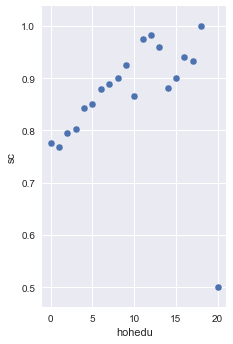

In [6]:
avg_enrollment_by_hohedu = pd.DataFrame(progresa_df[progresa_df.year == 97].groupby('hohedu').mean()['sc'])
avg_enrollment_by_hohedu.reset_index(level=0, inplace=True)
display(avg_enrollment_by_hohedu)
sns.pairplot(avg_enrollment_by_hohedu, x_vars = 'hohedu', y_vars = 'sc', size = 5, aspect = 0.7)

With the exception of a few outliers, it can be observed that an increase in the number of years of education of the head of the household led to a corresponding increase in the enrollment rate in the year 1997. In other words, the higher the education level of the head of the household, the higher are the chances of their children getting enrolled in a school.

# 1.5 Graphical exploration, part 2

Create a histogram of village enrollment rates **among poor households in treated villages**, before and after treatment. Specifically, for each village, calculate the average rate of enrollment of poor households in treated villages in 1997, then compute the average rate of enrollment of poor households in treated villages in 1998. Create two separate histograms showing the distribution of these average enrollments rates, one histogram for 1997 and one histogram for 1998. On each histogram, draw a vertical line that intersects the x-axis at the average value (across all households).
* Does there appear to be a difference? Is this difference statistically significant?
* Which D estimator in Schultz (2004) does this approach correspond to?

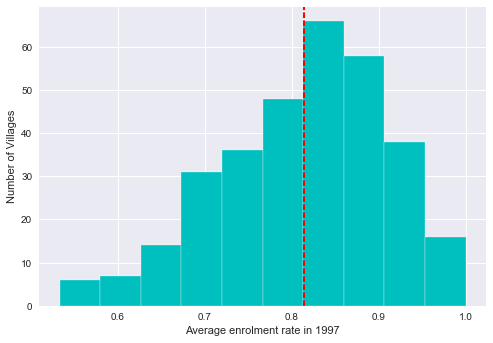

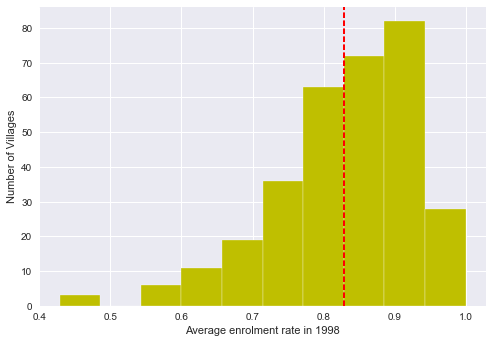

Mean of average enrolment in 1997 : 0.8138394110596501
Mean of average enrolment in 1998 : 0.8295362042630737
T-statistic (Avg Enrolment per village in 97 vs Avg Enrolment per village in 98) : -2.015713486515638
P value (Avg Enrolment per village in 97 vs Avg Enrolment per village in 98) : 0.04424870036572115


In [7]:
avg_enrolment_by_village_97 = pd.DataFrame(progresa_df[(progresa_df.year == 97)
                                                       & (progresa_df.poor == 1) & (progresa_df.progresa == 1)]
                                           .groupby('village').mean()['sc'])
avg_enrolment_by_village_98 = pd.DataFrame(progresa_df[(progresa_df.year == 98)
                                                       & (progresa_df.poor == 1) & (progresa_df.progresa == 1)]
                                           .groupby('village').mean()['sc'])
avg_enrolment_by_village_97.reset_index(level=0, inplace=True)
avg_enrolment_by_village_98.reset_index(level=0, inplace=True)


#subplot1 = figure.add_subplot(1,2,1)
plt.hist(avg_enrolment_by_village_97['sc'], color='c', alpha=1, ec='white')
plt.axvline(avg_enrolment_by_village_97['sc'].mean(), color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Average enrolment rate in 1997')
plt.ylabel('Number of Villages')
plt.show()

#subplot2 = figure.add_subplot(1,2,1)
plt.hist(avg_enrolment_by_village_98['sc'], color='y', alpha=1, ec='white')
plt.axvline(avg_enrolment_by_village_98['sc'].mean(), color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Average enrolment rate in 1998')
plt.ylabel('Number of Villages')
plt.show()

t_test_village_enrolment = stats.ttest_ind(avg_enrolment_by_village_97['sc'], avg_enrolment_by_village_98['sc'], 
                                           nan_policy='omit')
print('Mean of average enrolment in 1997 : ' + avg_enrolment_by_village_97['sc'].mean().astype('str'))
print('Mean of average enrolment in 1998 : ' + avg_enrolment_by_village_98['sc'].mean().astype('str'))
print('T-statistic (Avg Enrolment per village in 97 vs Avg Enrolment per village in 98) : ' +
      t_test_village_enrolment.statistic.astype('str'))
print('P value (Avg Enrolment per village in 97 vs Avg Enrolment per village in 98) : ' +
      t_test_village_enrolment.pvalue.astype('str'))


As the mean of average enrolment in 1998 (0.83) is slightly higher than that of 1997 (0.81), it can be said that the enrolment rate increased in 1998 compared to that in 1997. The p-value (0.044) of the t-test confirms that the difference is significant by a small amount.

## Part 2: Measuring Impact

### 2.1 Simple differences: T-test

Start out by estimating the impact of Progresa using "simple differences." Restricting yourself to data from 1998 (after treatment).
* calculate the average enrollment rate among **poor** households in the Treatment villages and the average enrollment rate among **poor** households in the control villages.
* Which difference estimator in Schultz (2004) does this approach correspond to?
* Use a t-test to determine if this difference is statistically significant. What do you conclude?

In [8]:
control_group_98 = progresa_df[(progresa_df['year'] == 98) & (progresa_df['poor'] == 1) 
                               & (progresa_df['progresa'] == 0)]

treatment_group_98 = progresa_df[(progresa_df['year'] == 98) & (progresa_df['poor'] == 1) 
                               & (progresa_df['progresa'] == 1)]

print('Average enrolment among poor households in control villages in 1998: ' + str(control_group_98['sc'].mean()))
print('Average enrolment among poor households in treatment villages in 1998 : ', str(treatment_group_98['sc'].mean()))
t_stat_avg_enrolment_98 = stats.ttest_ind(control_group_98['sc'], treatment_group_98['sc'], nan_policy='omit') 
print('T-stat (Average enrolment rate (Control vs Treatment in 1998)) : ' + str(t_stat_avg_enrolment_98.statistic))
print('P-value (Average enrolment rate (Control vs Treatment in 1998)) : ' + str(t_stat_avg_enrolment_98.pvalue))

Average enrolment among poor households in control villages in 1998: 0.80763695673
Average enrolment among poor households in treatment villages in 1998 :  0.846479121395
T-stat (Average enrolment rate (Control vs Treatment in 1998)) : -8.35872056742
P-value (Average enrolment rate (Control vs Treatment in 1998)) : 6.63634444738e-17


Since the p-value of the t-statistic is less than 0.05, we can conclude that progresa program had an impact on student enrolment in the year 1998. The difference in average enrolment between treatment and control villages ( 0.84 - 0.80 = 0.04 ) further affirms the analysis. 

### 2.2 Simple differences: Regression

Estimate the effects of Progresa on enrollment using a regression model, by regressing the 1998 enrollment rates **of the poor** on treatment assignment. Discuss the following:

* Based on this model, how much did Progresa increase the likelihood of a child enrolling?
* How does your regression estimate compare to your t-test estimate from part 2.1?
* Based on this regression model, can we reject the null hypothesis that the treatment effects are zero? 
* What is the counterfactual assumption underlying this regression?

In [9]:
data_year_1998 = progresa_df[(progresa_df['year'] == 98) & (progresa_df['poor'] == 1)]
lm = smf.ols(formula='sc ~ progresa', data=data_year_1998).fit()
display(lm.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     69.87
Date:                Mon, 21 Aug 2017   Prob (F-statistic):           6.64e-17
Time:                        16:02:11   Log-Likelihood:                -11926.
No. Observations:               27450   AIC:                         2.386e+04
Df Residuals:                   27448   BIC:                         2.387e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8076      0.004    220.676      0.000       0.800       0.815
progresa       0.0388      0.005      8.359      0.000       0.030       0.048
==============================================================================
Omnibus:                     7638.939   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15767.534
Skew:                          -1.767   Prob(JB):                         0.00
Kurtosis:                       4.140   Cond. No.                         3.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There are only two possibilities - enrolled in Progresa or not enrolled in Progresa. In case of the control group (not enrolled in Progresa) the intercept value will give the likelihood of a child enrolling in the program. In other words, for control groups in 1998, the likelihood that a child will enroll in Progresa is 0.8076, which is identical to the t-test performed in 2.1. For treatment groups, the slope value (Beta Coefficient) gives the increase in the likelihood that a child will enroll in this program. In other words, there is 0.0388 more likelihood of a child from the treatment group to be enrolled in the program in 1998. This gives the combined likelihood of 0.8464 (0.8076 + 0.0388). 

Since the p value is less than 0.05, the null hypothesis that the treatment effects are 0 can be rejected. 

Counterfactual assumption is asking the question, 'What would have happened if Progresa was not implemented?'. A possible counterfactual assumption would be that there would be no difference in the average enrolment rates between treatment and control groups if Progresa was not implemented.

### 2.3 Multiple Regression

Re-run the above regression estimated but this time include a set of control variables. Include, for instance, age, distance to a secondary school, gender, education of household head, indigenous, etc.

* How do the controls affect the point estimate of treatment effect?
* How do the controls affect the standard error on the treatment effect? 
* How do you interpret the differences (or similarities) between your estimates of 2.2 and 2.3?

In [10]:
glm = smf.ols(formula='sc ~ progresa + age + dist_cap + dist_sec + indig + sex + hohedu + min_dist',
             data=data_year_1998).fit()
display(glm.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     1282.
Date:                Mon, 21 Aug 2017   Prob (F-statistic):               0.00
Time:                        16:02:17   Log-Likelihood:                -7576.0
No. Observations:               27340   AIC:                         1.517e+04
Df Residuals:                   27331   BIC:                         1.524e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4620      0.010    140.217      0.000       1.442       1.482
progresa       0.0343      0.004      8.594      0.000       0.026       0.042
age           -0.0657      0.001    -96.293      0.000      -0.067      -0.064
dist_cap       0.0002   3.69e-05      5.681      0.000       0.000       0.000
dist_sec      -0.0107      0.001    -12.193      0.000      -0.012      -0.009
indig          0.0190      0.005      4.040      0.000       0.010       0.028
sex            0.0304      0.004      7.875      0.000       0.023       0.038
hohedu         0.0079      0.001     10.217      0.000       0.006       0.009
min_dist       0.0004   6.33e-05      6.112      0.000       0.000       0.001
==============================================================================
Omnibus:                     2922.409   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3958.536
Skew:                          -0.925   Prob(JB):                         0.00
Kurtosis:                       3.228   Cond. No.                     1.11e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

1. After adding the controls, the point estimate (beta coefficient) of the progresa treatment variable dropped from 0.0388 (simple linear model) to 0.0343 (multiple linear regression model).

2. After adding the controls, the standard error of the progresa treatment variable decreased from from 0.005 (simple linear model) to 0.004 (multiple linear regression model).

3. In the simple linear model, it is observed that progresa had a profound effect (0.0388 more likelihood) on a child being enrolled in school. But in the multiple regression model, we can see that, in addition to progresa, there are other factors such as gender, age, and distance to a secondary school (dist_sec) that may influence a child's likelihood of being enrolled in school.

### 2.4 Difference-in-Difference, version 1 (tabular)

Thus far, we have computed the effects of Progresa by estimating the difference in 1998 enrollment rates across villages. An alternative approach would be to compute the treatment effect using a difference-in-differences framework.

Begin by estimating the average treatment effects of the program for poor households using data from 1997 and 1998. Specifically, calculate the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages; then compute the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages. The difference between these two differences is your estimate.

* What is your estimate of the impact, and how does it compare to your earlier (simple difference) results?
* What is the counterfactual assumption underlying this estimate? 


In [11]:
diff_in_diff_matrix = pd.DataFrame(index=['Control Group', 'Treatment Group'],
                                   columns=['Avg Enrolment (Before Progresa - 1997)', 'Avg Enrolment (Post Progresa - 1998)'])

control_group_98 = progresa_df[(progresa_df['year'] == 98) & (progresa_df['poor'] == 1) 
                               & (progresa_df['progresa'] == 0)]

treatment_group_98 = progresa_df[(progresa_df['year'] == 98) & (progresa_df['poor'] == 1) 
                               & (progresa_df['progresa'] == 1)]

control_group_97 = progresa_df[(progresa_df['year'] == 97) & (progresa_df['poor'] == 1) 
                               & (progresa_df['progresa'] == 0)]

treatment_group_97 = progresa_df[(progresa_df['year'] == 97) & (progresa_df['poor'] == 1) 
                               & (progresa_df['progresa'] == 1)]

mean_sc_control_97 = control_group_97['sc'].mean()
mean_sc_treatment_97 = treatment_group_97['sc'].mean()
mean_sc_control_98 = control_group_98['sc'].mean()
mean_sc_treatment_98 = treatment_group_98['sc'].mean()

diff_in_diff_matrix.set_value('Control Group','Avg Enrolment (Before Progresa - 1997)', mean_sc_control_97)
diff_in_diff_matrix.set_value('Treatment Group','Avg Enrolment (Before Progresa - 1997)', mean_sc_treatment_97)
diff_in_diff_matrix.set_value('Control Group','Avg Enrolment (Post Progresa - 1998)', mean_sc_control_98)
diff_in_diff_matrix.set_value('Treatment Group','Avg Enrolment (Post Progresa - 1998)', mean_sc_treatment_98)
display(diff_in_diff_matrix)

diff_in_diff_estimate = (mean_sc_treatment_98 - mean_sc_treatment_97) - (mean_sc_control_98 - mean_sc_control_97)
print('The difference in difference estimate is : ' + str(diff_in_diff_estimate))



,Avg Enrolment (Before Progresa - 1997),Avg Enrolment (Post Progresa - 1998)
Control Group,0.815186,0.807637
Treatment Group,0.822697,0.846479


The difference in difference estimate is : 0.0313312803193


The difference in difference estimate of 0.0313 is lower than the simple difference result (0.0388). This is because the difference in difference negates the effect of all factors other than progresa that may have impacted the increase in enrolment.

The counterfactual assumption is that if the progam was not implemented, the treatment group would have the same increase or decrease in average enrolment as the control group.

### 2.5 Difference-in-Difference, version 1 (regression)

Now use a regression specification to estimate the average treatment effect of the program (on the poor) in a difference-in-differences framework. Include at least 5 control variables.

* What is your estimate of the impact of Progresa? Be very specific in interpreting your coefficients and standard errors, and make sure to specify exactly what units you are measuring and estimating.
* How do these estimates of the treatment effect compare to the estimates based on the simple difference?
* How do these estimates compare to the difference-in-difference estimates from 2.4 above? What accounts for these differences?
* What is the counterfactual assumption underlying this regression? 

In [12]:
progresa_df.loc[progresa_df['year'] == 97, 'post_treatment'] = 0
progresa_df.loc[progresa_df['year'] == 98, 'post_treatment'] = 1
diff_in_diff_lm = smf.ols(formula='sc ~ progresa + post_treatment + progresa*post_treatment + sex + dist_sec  + min_dist + dist_cap + hohedu + age + hohage + indig',
             data=progresa_df[progresa_df['poor'] == 1]).fit()
display(diff_in_diff_lm.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     2088.
Date:                Mon, 21 Aug 2017   Prob (F-statistic):               0.00
Time:                        16:02:21   Log-Likelihood:                -16535.
No. Observations:               58157   AIC:                         3.309e+04
Df Residuals:                   58145   BIC:                         3.320e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.4245      0.009    158.727      0.000       1.407       1.442
progresa                    0.0033      0.004      0.864      0.388      -0.004       0.011
post_treatment              0.0273      0.004      6.291      0.000       0.019       0.036
progresa:post_treatment     0.0313      0.006      5.688      0.000       0.021       0.042
sex                         0.0333      0.003     12.458      0.000       0.028       0.038
dist_sec                   -0.0098      0.001    -15.707      0.000      -0.011      -0.009
min_dist                    0.0004   4.38e-05      8.441      0.000       0.000       0.000
dist_cap                    0.0002   2.55e-05      7.369      0.000       0.000       0.000
hohedu                      0.0074      0.001     12.636      0.000       0.006       0.009
age                        -0.0658      0.000   -143.760      0.000      -0.067      -0.065
hohage                      0.0003      0.000      2.092      0.036    1.71e-05       0.001
indig                       0.0240      0.003      7.378      0.000       0.018       0.030
==============================================================================
Omnibus:                     5449.600   Durbin-Watson:                   1.492
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7147.537
Skew:                          -0.857   Prob(JB):                         0.00
Kurtosis:                       3.106   Cond. No.                     1.45e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

1. progresa*post_treatment : For families who were enrolled in the progresa program in 1998, the overall enrollment rate of children was 0.0313 units higher.
    post_treatment: The enrollment for the year 1998 was 0.0273 units higher than that of year 1997.
    
2. The point estimate in difference in difference model is lower as compared with the simple differences (regression) model. The higher point estimate in case of the simple differences model may be because it fails to discard other factors that may have contributed towards the increase in enrolment. The difference in difference model discards all other factors that may have influenced the increase in enrolment rate and hence, the lower value.

3. The point estimates in the difference in difference regression model are similar to the difference in difference estimates from 2.4

4. The counterfactual assumption is that if the progam was not implemented, the treatment group would have the same increase or decrease in average enrolment as the control group.

### 2.6 Difference-in-Difference, version 2

In the previous problem, you estimated a difference-in-differences model that compared changes in enrollment rates over time across treatment and control villages. An alternative approach would be to compare enrollment rates in 1998 between poor and non-poor across treatment and control villages. 

* How would we estimate this version of the treatment effects in a regression model? 
* What is the counterfactual assumption underlying this regression?
* How do these treatment effects compare to the estimates above?
* Discuss some possible explanations for differences or similarities 

In [13]:
diff_in_diff_lm_2 = smf.ols(formula='sc ~ progresa + poor + progresa*poor + sex + dist_sec  + min_dist + dist_cap + hohedu + age + hohage + indig',
             data=progresa_df[progresa_df['year'] == 98]).fit()
display(diff_in_diff_lm_2.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     1097.
Date:                Mon, 21 Aug 2017   Prob (F-statistic):               0.00
Time:                        16:02:23   Log-Likelihood:                -9214.1
No. Observations:               31971   AIC:                         1.845e+04
Df Residuals:                   31959   BIC:                         1.855e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.4850      0.014    102.419      0.000       1.457       1.513
progresa          0.0244      0.010      2.515      0.012       0.005       0.043
poor             -0.0238      0.008     -2.873      0.004      -0.040      -0.008
progresa:poor     0.0102      0.011      0.976      0.329      -0.010       0.031
sex               0.0305      0.004      8.442      0.000       0.023       0.038
dist_sec         -0.0109      0.001    -12.990      0.000      -0.013      -0.009
min_dist          0.0003   5.93e-05      5.645      0.000       0.000       0.000
dist_cap          0.0003   3.52e-05      7.370      0.000       0.000       0.000
hohedu            0.0086      0.001     11.424      0.000       0.007       0.010
age              -0.0662      0.001   -102.569      0.000      -0.067      -0.065
hohage         5.452e-05      0.000      0.311      0.756      -0.000       0.000
indig             0.0181      0.004      4.024      0.000       0.009       0.027
==============================================================================
Omnibus:                     3161.185   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4205.366
Skew:                          -0.887   Prob(JB):                         0.00
Kurtosis:                       3.109   Cond. No.                     2.04e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

progresa*poor : For families that were enrolled in the progresa program in the year 1998, the average enrolment rate increased by 0.0244.
poor: In 1998, The likelihood of children being enrolled in school was 0.0238 units less if the family was poor.

The counterfactual assumption underlying this regression is that in the absence of this program, the enrollment rate for poor and non-poor households would be the same.

In case of treatment effects, we can see that if a family was poor, the likelihood of them sending their children to school was 0.0238 units less. This is contrary to the purpose of the Progresa progam itself, which was meant to alleviate poverty in Mexico.

For poor families that were enrolled in the program (progresa*poor), the interaction is not statistically significant. A possible explanation for this would be that since the program is primarily intended for the poor, this factor is not statistically significant in determining the program's success.

### 2.7 Spillover effects (extra credit)

Thus far, we have focused on the impact of PROGRESA on poor households. Repeat your analysis in 2.5, using a double-difference regression to estimate the impact of PROGRESA on non-poor households. In other words, compare the difference in enrollments between 1997 and 1998 for non-poor households in treatment villages with the difference in enrollments between 1997 and 1998 for non-poor households in control villages.

* A: Describe one or two reasons why PROGRESA might have impacted non-poor households.
* B: Do you observe any impacts of PROGRESA on the non-poor?
* C: What is the identifying assumption that you are using to estimate the impact of PROGRESA on non-poor households.

In [14]:
did_lm_non_poor = smf.ols(formula='sc ~ progresa + post_treatment + progresa*post_treatment + sex + dist_sec  + min_dist + dist_cap + hohedu + age + hohage + indig',
             data=progresa_df[progresa_df['poor'] == 0]).fit()
display(did_lm_non_poor.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     388.0
Date:                Mon, 21 Aug 2017   Prob (F-statistic):               0.00
Time:                        16:02:25   Log-Likelihood:                -3642.3
No. Observations:               10378   AIC:                             7309.
Df Residuals:                   10366   BIC:                             7396.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.4764      0.024     61.778      0.000       1.430       1.523
progresa                    0.0246      0.009      2.651      0.008       0.006       0.043
post_treatment              0.0394      0.011      3.659      0.000       0.018       0.060
progresa:post_treatment    -0.0030      0.014     -0.214      0.830      -0.030       0.024
sex                         0.0303      0.007      4.490      0.000       0.017       0.044
dist_sec                   -0.0154      0.002     -8.726      0.000      -0.019      -0.012
min_dist                -8.567e-05      0.000     -0.740      0.459      -0.000       0.000
dist_cap                    0.0006   7.62e-05      8.293      0.000       0.000       0.001
hohedu                      0.0090      0.001      7.555      0.000       0.007       0.011
age                        -0.0686      0.001    -59.984      0.000      -0.071      -0.066
hohage                   7.182e-05      0.000      0.214      0.831      -0.001       0.001
indig                       0.0129      0.010      1.237      0.216      -0.008       0.033
==============================================================================
Omnibus:                      840.967   Durbin-Watson:                   1.504
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              800.243
Skew:                          -0.620   Prob(JB):                    1.70e-174
Kurtosis:                       2.439   Cond. No.                     1.27e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

A. One possible reason why non-poor households may have enrolled in the program is peer influence. Seeing the poor households sending their children to school may have influenced the non-poor households to send their children to school too.

B. The post-treatment variable, which gives us the average enrolment rates for non-poor households, is statistically significant. This indicates that the average enrolment rates non-poor households increased by 0.0394 from 1997-1998, in spite of not getting the program subsidy.

C. The  identifying assumption that we are using to estimate the impact of Progresa on non-poor households is that the non-poor households are not eligible for subsidy from the program even if they send their children to school.

### 2.8 Summary

Based on all the analysis you have undertaken to date, do you thik that Progresa had a causal impact on the enrollment rates of poor households in Mexico?

Yes, the Progresa program definitely had an impact on the enrollment rates of poor households in Mexico. This is evident from the increase in average enrolment rates for poor households from 1997 to 1998. 

But whether or not, this program had a causal effect, is difficult to say with the data in hand (1997-1998). To comment on the causal effect, one needs to analyse the increase in enrollment over a period of a few years. With that said, there may be other factors that have contributed towards the increase in enrollment rates.